In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
plt.rc("font", family=font_name)

import matplotlib as mpl
mpl.rcParams["axes.unicode_minus"] = False

import tensorflow as tf

import datetime

import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm import plot_importance, plot_tree, plot_metric


## 중식 데이터 불러오기

In [39]:
train = pd.read_csv('data/lunch_train_exencoding.csv')
train.head()

,datetime,season,month,date,weekdays,vacation,worker_number,real_number,vacation_number,biztrip_number,...,rain,wind,humidity,discomfort_index,perceived_temperature,lunch_rice,lunch_soup,lunch_main,new_lunch,lunch_number
0,2016-02-01,겨울,2,1,월,N,2601,2401,50,150,...,0.0,1.3,43.9,39.275534,0.641548,밥,오징어찌개,쇠불고기,N,1039
1,2016-02-02,겨울,2,2,화,N,2601,2378,50,173,...,0.0,0.8,47.5,36.562925,-0.160634,밥,김치찌개,가자미튀김,N,867
2,2016-02-03,겨울,2,3,수,N,2601,2365,56,180,...,0.0,0.6,57.1,35.796707,0.964631,카레덮밥,팽이장국,치킨핑거,N,1017
3,2016-02-04,겨울,2,4,목,N,2601,2277,104,220,...,0.0,0.7,53.4,38.396068,2.181494,밥,쇠고기무국,주꾸미볶음,N,978
4,2016-02-05,겨울,2,5,금,Y,2601,2142,278,181,...,0.0,1.0,44.4,41.575228,3.073400,밥,떡국,돈육씨앗강정,N,925


### 결측치 제거

In [40]:
train.isnull().sum()
train = train.replace(np.NaN, 0)

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               1205 non-null   object 
 1   season                 1205 non-null   object 
 2   month                  1205 non-null   int64  
 3   date                   1205 non-null   int64  
 4   weekdays               1205 non-null   object 
 5   vacation               1205 non-null   object 
 6   worker_number          1205 non-null   int64  
 7   real_number            1205 non-null   int64  
 8   vacation_number        1205 non-null   int64  
 9   biztrip_number         1205 non-null   int64  
 10  overtime_number        1205 non-null   int64  
 11  telecom_number         1205 non-null   int64  
 12  temperature            1205 non-null   float64
 13  rain                   1205 non-null   float64
 14  wind                   1205 non-null   float64
 15  humi

In [42]:
weekday = {'월':1, '화':2, '수':3, '목':4, '금':5}
vacation = {'Y':1, 'N':0}
season = {'봄':1, '여름':2, '가을':3, '겨울':4}
new_lunch = {'Y':1, 'N':0}

train['weekdays'] = train['weekdays'].map(weekday)
train['vacation'] = train['vacation'].map(vacation)
train['season'] = train['season'].map(season)
train['new_lunch'] = train['new_lunch'].map(new_lunch)

In [43]:
train.head()

,datetime,season,month,date,weekdays,vacation,worker_number,real_number,vacation_number,biztrip_number,...,rain,wind,humidity,discomfort_index,perceived_temperature,lunch_rice,lunch_soup,lunch_main,new_lunch,lunch_number
0,2016-02-01,4,2,1,1,0,2601,2401,50,150,...,0.0,1.3,43.9,39.275534,0.641548,밥,오징어찌개,쇠불고기,0,1039
1,2016-02-02,4,2,2,2,0,2601,2378,50,173,...,0.0,0.8,47.5,36.562925,-0.160634,밥,김치찌개,가자미튀김,0,867
2,2016-02-03,4,2,3,3,0,2601,2365,56,180,...,0.0,0.6,57.1,35.796707,0.964631,카레덮밥,팽이장국,치킨핑거,0,1017
3,2016-02-04,4,2,4,4,0,2601,2277,104,220,...,0.0,0.7,53.4,38.396068,2.181494,밥,쇠고기무국,주꾸미볶음,0,978
4,2016-02-05,4,2,5,5,1,2601,2142,278,181,...,0.0,1.0,44.4,41.575228,3.073400,밥,떡국,돈육씨앗강정,0,925


In [45]:
X_train = train[['month', 'date', 'weekdays', 'worker_number',
                 'real_number', 'vacation_number', 'biztrip_number', 'overtime_number', 
               'telecom_number', 'temperature', 'rain', 'lunch_number']]
y_train = train['lunch_number']

In [46]:
train.corr()[['lunch_number']]

,lunch_number
season,0.035518
month,-0.154664
date,-0.097392
weekdays,-0.731563
vacation,-0.181528
worker_number,-0.115529
real_number,0.286810
vacation_number,-0.391975
biztrip_number,-0.512680
overtime_number,0.535611


<AxesSubplot:xlabel='weekdays', ylabel='lunch_number'>

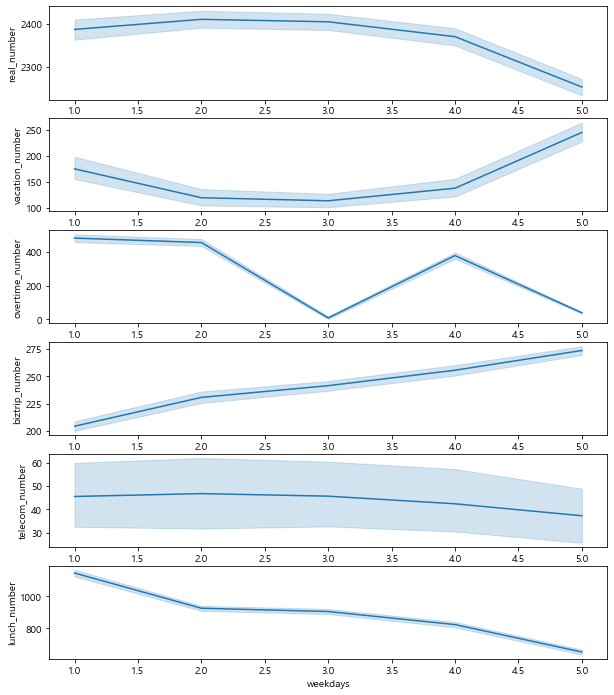

In [12]:
# 그래프

fig, ax = plt.subplots(6)
fig.set_size_inches(10, 12)

sns.lineplot(data=train, x='weekdays', y='real_number', ax=ax[0])
sns.lineplot(data=train, x='weekdays', y='vacation_number', ax=ax[1])
sns.lineplot(data=train, x='weekdays', y='overtime_number', ax=ax[2])
sns.lineplot(data=train, x='weekdays', y='biztrip_number', ax=ax[3])
sns.lineplot(data=train, x='weekdays', y='telecom_number', ax=ax[4])
sns.lineplot(data=train, x='weekdays', y='lunch_number', ax=ax[5])

### XGBClassifier

In [47]:
xgbc = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=3)
xgbc.fit(X_train, y_train)

print("훈련 정확도 : ", xgbc.score(X_train, y_train))

[13:40:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
훈련 정확도 :  0.9103734439834025


In [73]:
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(300,600,100),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 3, 'n_estimators': 600}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

{'colsample_bylevel': 1, 'colsample_bytree': 1, 'max_depth': 2, 'n_estimators': 500}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=None, colsample_bytree=0.7, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=600, n_jobs=1, nthread=None, num_parallel_tree=None,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=True, subsample=1,
             tree_method=None, validate_parameters=None, verbosity=None)

In [74]:
y_pred = grid_search.predict(X_test)

In [75]:
y_pred

array([ 386.4741 ,  864.3267 ,  747.80035,  942.0679 ,  903.6705 ,
       1326.6628 ,  812.2415 ,  478.84268, 1195.3596 ,  793.5443 ,
        610.4721 ,  691.9632 ,  884.9721 , 1045.6011 ,  839.0294 ,
        778.0219 , 1096.7781 ,  901.40106, 1163.3026 ,  817.692  ,
        683.21265,  507.05832,  777.7377 ,  515.6435 , 1069.6345 ,
       1170.6385 , 1056.8928 ,  661.6544 ,  839.33484,  482.7034 ,
       1000.2582 ,  900.80536,  898.16113,  789.75415,  805.5245 ,
        720.29565,  543.4981 , 1026.6644 ,  552.4514 ,  596.4292 ,
        948.0315 ,  929.5834 ,  766.41644,  507.14572, 1166.2216 ,
       1157.5983 ,  733.11005, 1225.0798 ,  844.73334, 1167.912  ,
        731.0244 , 1141.3071 , 1053.7039 ,  842.60187,  915.7973 ,
        848.0216 , 1049.9751 ,  408.33893,  959.0862 ,  805.4794 ,
       1112.6954 ,  695.4723 , 1317.3793 ,  839.6108 , 1105.257  ,
        768.4787 ,  679.8321 , 1076.6226 ,  801.30865,  682.78754,
        729.5959 , 1255.119  ,  549.99365,  768.53455, 1210.95

### XGBRegressor

In [49]:
label = train['lunch_number']

In [53]:
del train['datetime']
del train['lunch_rice']
del train['lunch_soup']
del train['lunch_main']

In [48]:
train.head()

,datetime,season,month,date,weekdays,vacation,worker_number,real_number,vacation_number,biztrip_number,...,rain,wind,humidity,discomfort_index,perceived_temperature,lunch_rice,lunch_soup,lunch_main,new_lunch,lunch_number
0,2016-02-01,4,2,1,1,0,2601,2401,50,150,...,0.0,1.3,43.9,39.275534,0.641548,밥,오징어찌개,쇠불고기,0,1039
1,2016-02-02,4,2,2,2,0,2601,2378,50,173,...,0.0,0.8,47.5,36.562925,-0.160634,밥,김치찌개,가자미튀김,0,867
2,2016-02-03,4,2,3,3,0,2601,2365,56,180,...,0.0,0.6,57.1,35.796707,0.964631,카레덮밥,팽이장국,치킨핑거,0,1017
3,2016-02-04,4,2,4,4,0,2601,2277,104,220,...,0.0,0.7,53.4,38.396068,2.181494,밥,쇠고기무국,주꾸미볶음,0,978
4,2016-02-05,4,2,5,5,1,2601,2142,278,181,...,0.0,1.0,44.4,41.575228,3.073400,밥,떡국,돈육씨앗강정,0,925


In [54]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.3,
                                                   random_state=200)

In [55]:
xgbr = XGBRegressor(n_estimators=400, learning_rate=0.1, max_depth=3, objective="reg:squarederror")
xgbr.fit(X_train, y_train)

print("훈련 정확도 : ", xgbr.score(X_train, y_train))
print("테스트 정확도 : ", xgbr.score(X_test, y_test))

훈련 정확도 :  0.9999669105705641
테스트 정확도 :  0.9996760308185474


In [66]:
cross_val = cross_validate(estimator=xgbr, X=train, y=label, cv=5)
cross_val

{'fit_time': array([0.17003703, 0.16654205, 0.17303896, 0.16503692, 0.16603661]),
 'score_time': array([0.0030005 , 0.00200105, 0.00200009, 0.00300026, 0.00200105]),
 'test_score': array([0.99976173, 0.99980403, 0.99963755, 0.99937376, 0.99971151])}

In [65]:
print("테스트 정확도 평균 : ", cross_val["test_score"].mean())

테스트 정확도 평균 :  0.999657715976924


### 